# Harnessing Machine Learning for Effective P_Wave Analysis in Cardiovascular Diagnostics

### Importing Required Packages

In [88]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install xgboost tabulate scikit-learn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

### Loading Data

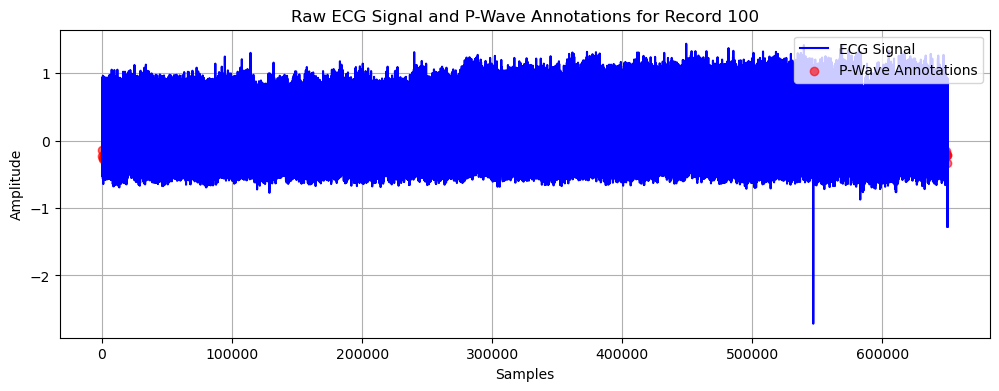

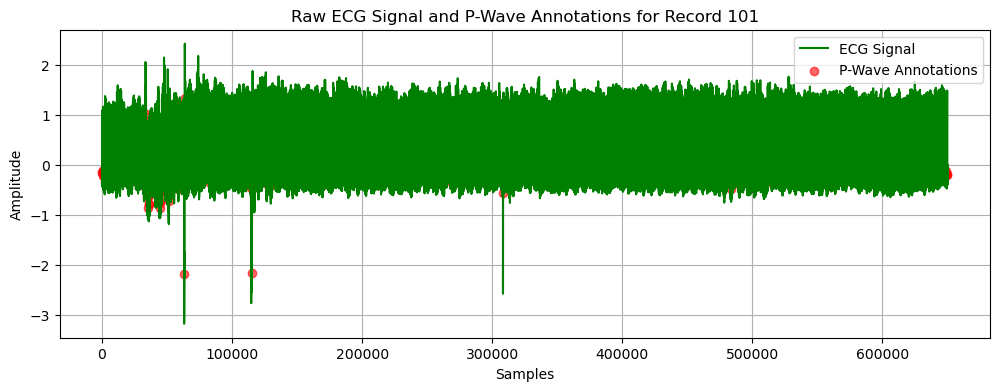

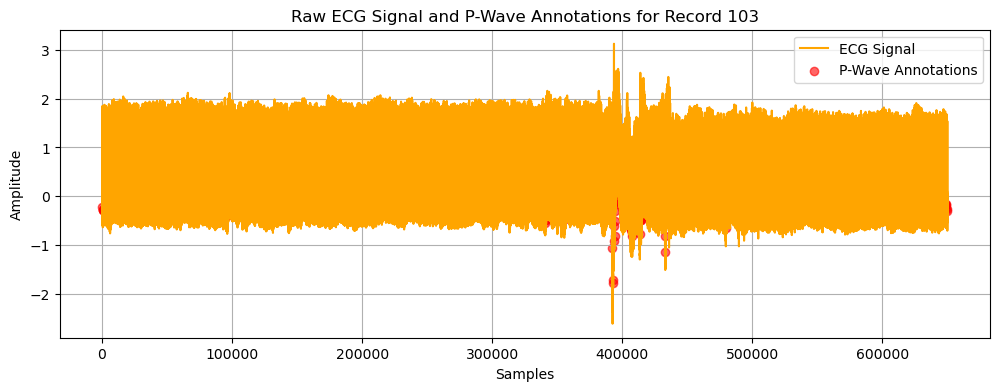

In [89]:
dataset_directory = r'C:\Users\likhi\Downloads\mit-bih-arrhythmia-database-p-wave-annotations-1.0.0\mit-bih-arrhythmia-database-p-wave-annotations-1.0.0'

# Function to load and plot P-wave annotations for each record
def plot_pwave_annotations(record_names):
    # Define colors for the records
    colors = ['blue', 'green', 'orange']  

    # Loop through the first 3 records only
    for i, record in enumerate(record_names[:3]):  
        record_data = wfdb.rdrecord(os.path.join(dataset_directory, record))
        annotations = wfdb.rdann(os.path.join(dataset_directory, record), 'pwave')
        plt.figure(figsize=(12, 4))
        plt.plot(record_data.p_signal[:, 0], label='ECG Signal', color=colors[i % len(colors)])
        plt.scatter(annotations.sample, record_data.p_signal[annotations.sample, 0], 
                    color='red', label='P-Wave Annotations', alpha=0.6)
       
        plt.title(f'Raw ECG Signal and P-Wave Annotations for Record {record}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        
        
        plt.legend(loc='upper right')
        plt.grid()
        
        plt.show()

# Load and plot P-wave annotations for the records
plot_pwave_annotations(record_names)


### Signal Processing with Bandpass Filtering

In [90]:
# Define a bandpass filter function
def bandpass_filter(signal, lowcut, highcut, sampling_freq, order=4):
    nyquist = 0.5 * sampling_freq
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


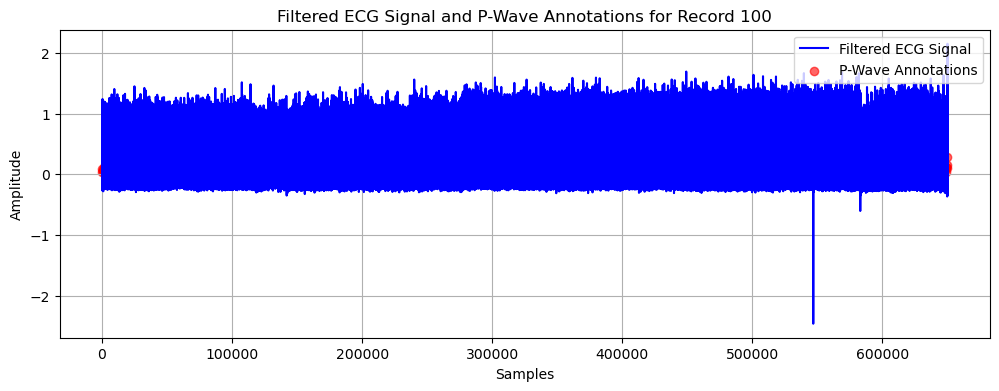

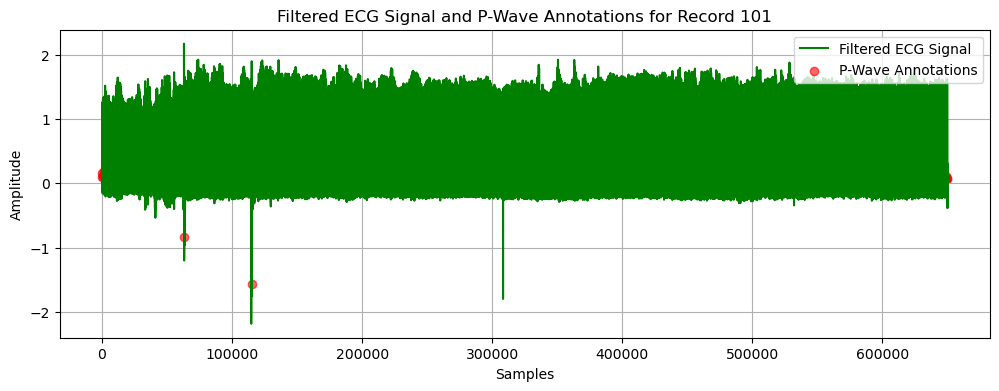

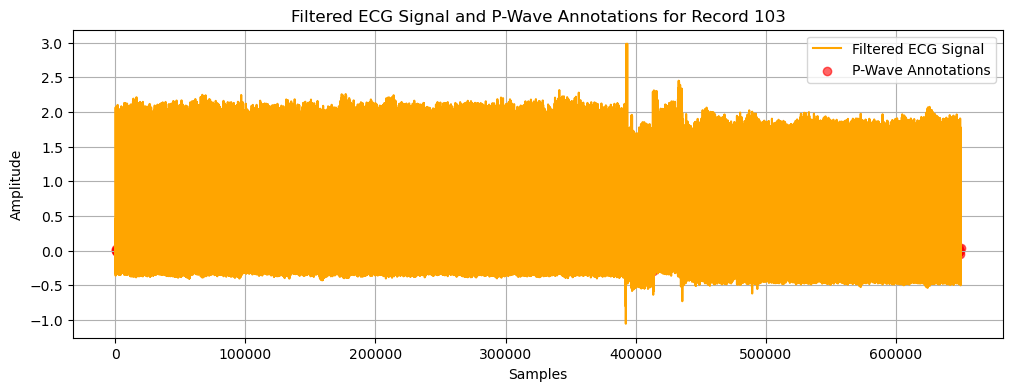

In [91]:
def plot_filtered_pwave_annotations(record_names):
    colors = ['blue', 'green', 'orange']
    for i, record in enumerate(record_names[:3]):  
        record_data = wfdb.rdrecord(os.path.join(dataset_directory, record))
        sampling_freq = record_data.fs
        filtered_ecg = bandpass_filter(record_data.p_signal[:, 0], 0.5, 40, sampling_freq)
        annotations = wfdb.rdann(os.path.join(dataset_directory, record), 'pwave')
        plt.figure(figsize=(12, 4))
        plt.plot(filtered_ecg, label='Filtered ECG Signal', color=colors[i % len(colors)])
        plt.scatter(annotations.sample, filtered_ecg[annotations.sample], color='red', label='P-Wave Annotations', alpha=0.6)
        
        
        plt.title(f'Filtered ECG Signal and P-Wave Annotations for Record {record}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        
        
        plt.legend(loc='upper right')
        plt.grid()
        
        
        plt.show()

plot_filtered_pwave_annotations(record_names)

### Feature Extraction from P-Wave Records Using Sliding Window Technique

In [92]:
def z_score_normalize(data):
    return (data - np.mean(data)) / np.std(data)

def sliding_window(data, win_size, overlap):
    step = int(win_size * (1 - overlap))  
    return np.lib.stride_tricks.sliding_window_view(data, window_shape=win_size)[::step]

def extract_pwave_features(record_names, dataset_dir, window_size, overlap, fs=360):
    feature_list = []
   
    for record in record_names:
        print(f"Processing P-Wave record: {record}")
        record_path = os.path.join(dataset_dir, record)
        record_data = wfdb.rdrecord(record_path)
        pwave_windows = sliding_window(record_data.p_signal[:, 0], window_size, overlap)
       
        annotations = wfdb.rdann(record_path, 'pwave')
        p_wave_indices = annotations.sample
       
        for i, window in enumerate(pwave_windows):
            
            start = i * int(window_size * (1 - overlap))
            end = start + window_size

            # Normalize the window
            normalized_window = z_score_normalize(window)
           
            # Calculate basic features from the normalized window
            min_value = np.min(normalized_window)
            max_value = np.max(normalized_window)
            std_dev = np.std(normalized_window)
            mean_value = np.mean(normalized_window)
            median_value = np.median(normalized_window)
            skewness = skew(normalized_window)
            kurt = kurtosis(normalized_window)

            # Find local maxima and minima
            local_maxima_indices, _ = find_peaks(normalized_window, distance=fs//2)
            local_minima_indices, _ = find_peaks(-normalized_window, distance=fs//2)

            # Calculate average local maxima and minima
            avg_local_max = np.mean(normalized_window[local_maxima_indices]) if local_maxima_indices.size > 0 else np.nan
            avg_local_min = np.mean(normalized_window[local_minima_indices]) if local_minima_indices.size > 0 else np.nan

            # Calculate amplitude as the difference between max and min
            amplitude = (np.max(normalized_window[local_maxima_indices]) - np.min(normalized_window[local_minima_indices])
                         if local_maxima_indices.size > 0 and local_minima_indices.size > 0 else np.nan)

            # Heart rate based on peaks
            num_peaks = len(local_maxima_indices)
            heart_rate = (num_peaks / (window_size / fs)) * 60

            # RR intervals
            rr_intervals = np.diff(local_maxima_indices) / fs if len(local_maxima_indices) > 1 else [np.nan]
            avg_rr_interval = np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan

            # Frequency-domain features using Welch's method
            frequencies, psd = welch(normalized_window, fs)
            max_freq = frequencies[np.argmax(psd)]
            avg_psd = np.mean(psd)
           
            # Check if any P-wave annotation falls within the current window
            p_wave_present = 1 if np.any((p_wave_indices >= start) & (p_wave_indices < end)) else 0

            
            feature_list.append([
                record, min_value, max_value, std_dev, mean_value, median_value, skewness, kurt,
                avg_local_max, avg_local_min, amplitude,
                heart_rate, avg_rr_interval, max_freq, avg_psd, p_wave_present
            ])

    return pd.DataFrame(feature_list, columns=[
        "Record", "Minimum", "Maximum", "StdDev", "Mean", "Median", "Skewness", "Kurtosis",
        "Avg_Local_Max", "Avg_Local_Min", "Amplitude", "HeartRate", "Avg_RR_Interval",
        "MaxFreq", "Avg_PSD", "P_Wave"  
    ])


In [93]:
# Set parameters for P-Wave dataset processing
win_size = 360  
overlap_ratio = 0.5  

# Calculate features for P-Wave records
features_dataframe = extract_pwave_features(
    record_names=record_names,
    dataset_dir=dataset_directory,
    window_size=win_size,
    overlap=overlap_ratio
)




Processing P-Wave record: 100
Processing P-Wave record: 101
Processing P-Wave record: 103
Processing P-Wave record: 106
Processing P-Wave record: 117
Processing P-Wave record: 119
Processing P-Wave record: 122
Processing P-Wave record: 207
Processing P-Wave record: 214
Processing P-Wave record: 222
Processing P-Wave record: 223
Processing P-Wave record: 231


### Feature Descriptions for ECG Signal Analysis

### Dataset Overview And Preprocessing  

In [76]:
features_dataframe.head()

,Minimum,Maximum,Median,Skewness,Kurtosis,Avg_Local_Max,Avg_Local_Min,Amplitude,HeartRate,Avg_RR_Interval,MaxFreq,Avg_PSD,P_Wave
0,-1.623454,7.880266,-0.180297,5.203211,33.540753,4.219574,-1.025072,9.327725,120.0,0.641667,1.40625,0.008278,1
1,-1.328089,7.387420,-0.057693,5.097652,30.881576,3.650091,-1.328089,8.715509,120.0,0.505556,5.62500,0.005138,1
2,-1.121105,5.739295,-0.224321,4.180059,18.243906,5.694456,-0.908119,6.860400,120.0,0.813889,1.40625,0.000586,1
3,-1.543570,8.366080,-0.118653,5.867531,40.638532,4.479943,-0.944457,9.909651,120.0,0.652778,7.03125,0.018941,1
4,-2.031479,8.139996,-0.172904,5.621041,38.451895,3.932858,-1.321841,10.171475,120.0,0.580556,4.21875,0.000677,1


In [10]:
features_dataframe.tail()

,Record,Minimum,Maximum,StdDev,Mean,Median,Skewness,Kurtosis,Avg_Local_Max,Avg_Local_Min,Amplitude,HeartRate,Avg_RR_Interval,MaxFreq,Avg_PSD,P_Wave
43315,231,-2.978682,5.117062,1.0,-5.921189e-17,-0.217280,1.109386,5.533319,3.379919,-1.667630,8.095744,120.0,0.577778,1.40625,0.001056,1
43316,231,-2.958125,5.659523,1.0,1.480297e-17,-0.236762,1.676695,8.712786,2.772436,-1.737001,8.617648,120.0,0.536111,1.40625,0.006385,1
43317,231,-3.044581,5.372840,1.0,-2.960595e-17,-0.233163,1.394752,6.848585,3.495755,-1.664124,8.417421,120.0,0.636111,1.40625,0.000610,1
43318,231,-3.064861,5.441028,1.0,-7.894919e-17,-0.215388,1.471818,7.364500,2.676614,-1.763460,8.505888,120.0,0.533333,1.40625,0.006747,1
43319,231,-2.955710,5.680052,1.0,-6.908054e-17,-0.170545,1.721972,9.417574,3.832034,-1.598161,8.635762,120.0,0.669444,1.40625,0.000605,0


In [12]:
# Display the shape of the DataFrame
print("Shape of the DataFrame:", features_dataframe.shape)

Shape of the DataFrame: (43320, 16)


In [14]:
# Display data types of each column
print("Data Types:\n", features_dataframe.dtypes)

Data Types:
 Record              object
Minimum            float64
Maximum            float64
StdDev             float64
Mean               float64
Median             float64
Skewness           float64
Kurtosis           float64
Avg_Local_Max      float64
Avg_Local_Min      float64
Amplitude          float64
HeartRate          float64
Avg_RR_Interval    float64
MaxFreq            float64
Avg_PSD            float64
P_Wave               int64
dtype: object


In [16]:
# Display unique values in each column
for column in features_dataframe.select_dtypes(include=['object']).columns:
    print(f"Unique values in {column}:\n", features_dataframe[column].unique())

Unique values in Record:
 ['100' '101' '103' '106' '117' '119' '122' '207' '214' '222' '223' '231']


In [17]:
# Check for duplicate rows
duplicates = features_dataframe.duplicated().sum()
print("Number of duplicate rows:", duplicates)


Number of duplicate rows: 0


In [19]:
# Count unique classes and their counts
class_counts = features_dataframe['P_Wave'].value_counts()
print("\nClass counts:")
print(class_counts)


Class counts:
P_Wave
1    37844
0     5476
Name: count, dtype: int64


In [94]:
# Check for missing values
missing_values = features_dataframe.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Check if there are any missing values
if missing_values.any():
    print("\nMissing values found. Proceeding with imputation...")

    # Impute missing values using forward fill
    features_dataframe.fillna(method='ffill', inplace=True)

    # Confirm that there are no missing values left
    missing_values_after_imputation = features_dataframe.isnull().sum()
    print("\nMissing Values After Imputation:\n", missing_values_after_imputation)
else:
    print("\nNo missing values found.")

Missing Values in Each Column:
 Record                0
Minimum               0
Maximum               0
StdDev                0
Mean                  0
Median                0
Skewness              0
Kurtosis              0
Avg_Local_Max         0
Avg_Local_Min         0
Amplitude             0
HeartRate             0
Avg_RR_Interval    1273
MaxFreq               0
Avg_PSD               0
P_Wave                0
dtype: int64

Missing values found. Proceeding with imputation...

Missing Values After Imputation:
 Record             0
Minimum            0
Maximum            0
StdDev             0
Mean               0
Median             0
Skewness           0
Kurtosis           0
Avg_Local_Max      0
Avg_Local_Min      0
Amplitude          0
HeartRate          0
Avg_RR_Interval    0
MaxFreq            0
Avg_PSD            0
P_Wave             0
dtype: int64


In [95]:
# Remove 'Record', 'Mean', and 'Standard_Deviation' columns
columns_to_remove = ['Record', 'Mean', 'StdDev']
features_dataframe.drop(columns=[col for col in columns_to_remove if col in features_dataframe.columns], inplace=True)
print(f"\nColumns removed: {', '.join(columns_to_remove)}")


Columns removed: Record, Mean, StdDev


### Visualizing ECG Sliding Windows with Peak Analysis

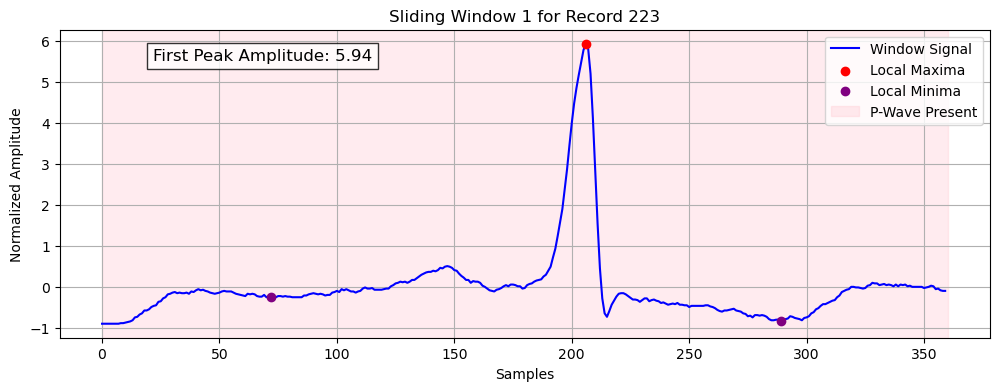

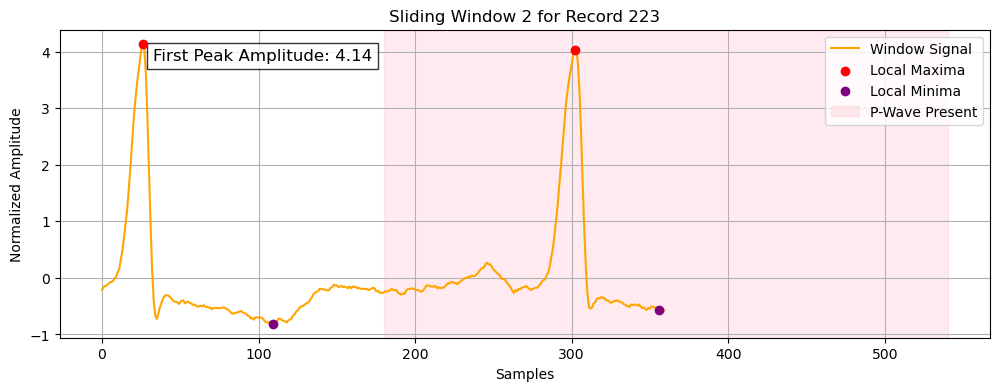

In [86]:
def plot_sliding_windows_with_features(record_name, dataset_dir, window_size, overlap, fs=360):
    # Load the record data and annotations
    record_path = os.path.join(dataset_dir, record_name)
    record_data = wfdb.rdrecord(record_path)
    annotations = wfdb.rdann(record_path, 'pwave')
    p_wave_indices = annotations.sample

    # Get the ECG signal
    ecg_signal = record_data.p_signal[:, 0]
    
    # Generate sliding windows
    pwave_windows = sliding_window(ecg_signal, window_size, overlap)
    
    # Set colors for each window
    colors = ['blue', 'orange']

    # Plot features for the first three windows
    for i in range(2):  
        plt.figure(figsize=(12, 4))
        window = pwave_windows[i]
        
        
        normalized_window = z_score_normalize(window)
        
        
        local_maxima_indices, _ = find_peaks(normalized_window, distance=fs // 2)
        local_minima_indices, _ = find_peaks(-normalized_window, distance=fs // 2)
        
        
        amplitude = None
        if local_maxima_indices.size > 0:
            first_peak_index = local_maxima_indices[0]
            amplitude = normalized_window[first_peak_index]  

        
        plt.plot(normalized_window, color=colors[i % len(colors)], label='Window Signal')
        
        
        if local_maxima_indices.size > 0:
            plt.scatter(local_maxima_indices, normalized_window[local_maxima_indices], color='red', 
                        label='Local Maxima', zorder=5)
        
        if local_minima_indices.size > 0:
            plt.scatter(local_minima_indices, normalized_window[local_minima_indices], color='purple', 
                        label='Local Minima', zorder=5)

        
        start_idx = i * int(window_size * (1 - overlap))
        end_idx = start_idx + window_size
        p_wave_present = np.any((p_wave_indices >= start_idx) & (p_wave_indices < end_idx))
        
        if p_wave_present:
            plt.axvspan(start_idx, end_idx, color='pink', alpha=0.3, label='P-Wave Present')

        
        if amplitude is not None:
            plt.text(0.1, 0.9, f'First Peak Amplitude: {amplitude:.2f}', transform=plt.gca().transAxes,
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

        
        plt.title(f'Sliding Window {i+1} for Record {record_name}')
        plt.xlabel('Samples')
        plt.ylabel('Normalized Amplitude')
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()


chosen_record_name = record_names[10]  


plot_sliding_windows_with_features(chosen_record_name, dataset_directory, window_size=win_size, overlap=overlap_ratio)


### Exploratory Data Analysis 

In [87]:
# Display summary statistics
summary_statistics = features_dataframe.describe()
print(summary_statistics)

            Minimum       Maximum        StdDev          Mean        Median  \
count  43320.000000  43320.000000  4.332000e+04  4.332000e+04  43320.000000   
mean      -1.770151      5.302242  1.000000e+00  1.198985e-18     -0.176093   
std        1.116503      1.839451  8.763721e-17  1.828216e-16      0.130904   
min       -6.535872      0.629572  1.000000e+00 -1.894781e-15     -0.661675   
25%       -2.083096      4.015185  1.000000e+00 -6.908054e-17     -0.257945   
50%       -1.277198      5.567275  1.000000e+00  0.000000e+00     -0.190553   
75%       -0.997096      6.737018  1.000000e+00  7.894919e-17     -0.109570   
max       -0.426722     12.189590  1.000000e+00  1.973730e-15      0.631219   

           Skewness      Kurtosis  Avg_Local_Max  Avg_Local_Min     Amplitude  \
count  43320.000000  43320.000000   43320.000000   43320.000000  43320.000000   
mean       2.832461     14.818512       3.185514      -1.147744      7.027156   
std        1.983655     10.369919       1.243

#### 1.Distribution of P-Wave Labels

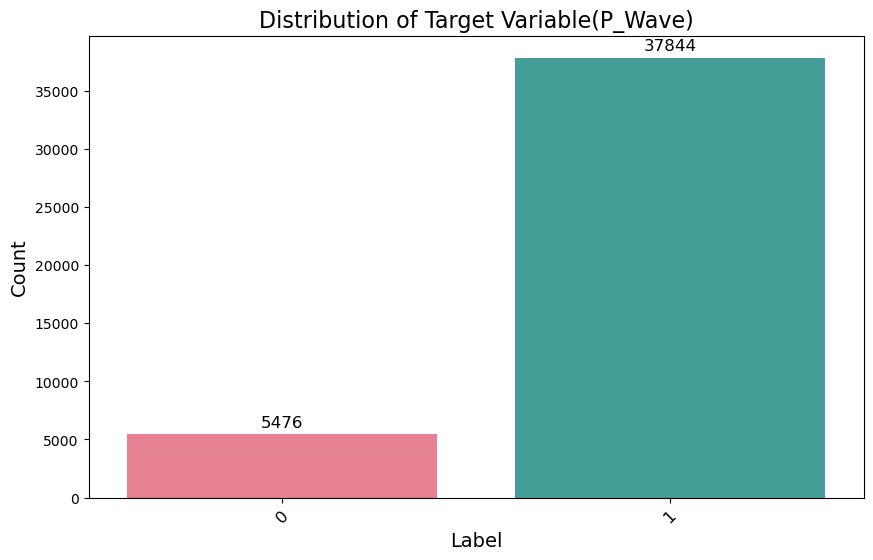

In [39]:
plt.figure(figsize=(10, 6)) 

sns.countplot(x='P_Wave', data=features_dataframe, palette='husl') 

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')


plt.title('Distribution of Target Variable(P_Wave)', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  

plt.show()

####  2.Feature Correlation Analysis

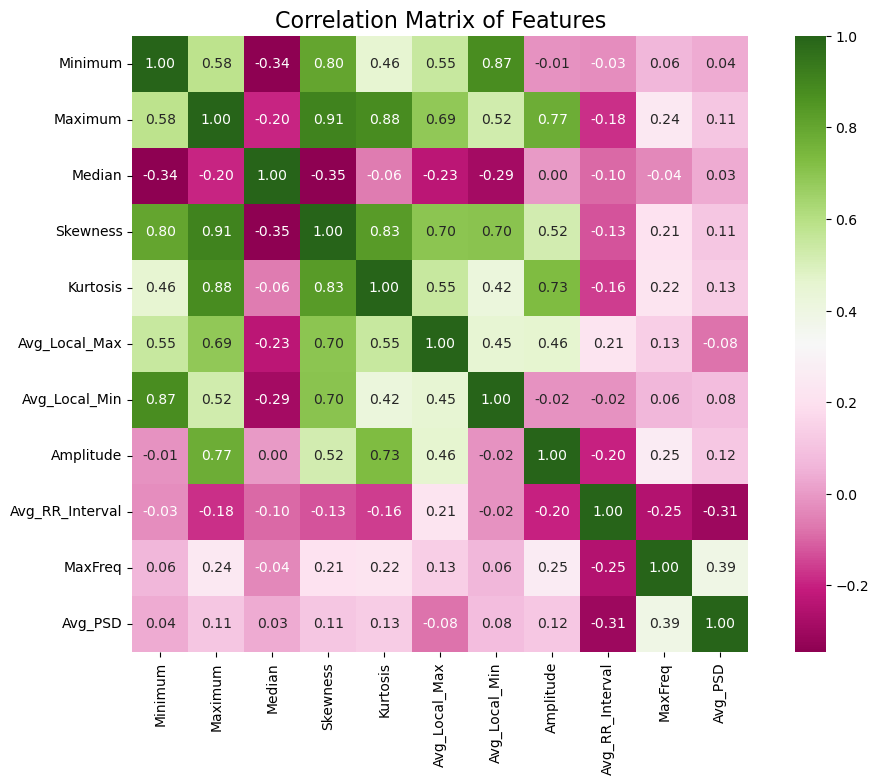

In [40]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = features_dataframe.drop(columns=['P_Wave', 'HeartRate']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='PiYG', square=True)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()


####  3.Univariate Analysis of Numerical Features

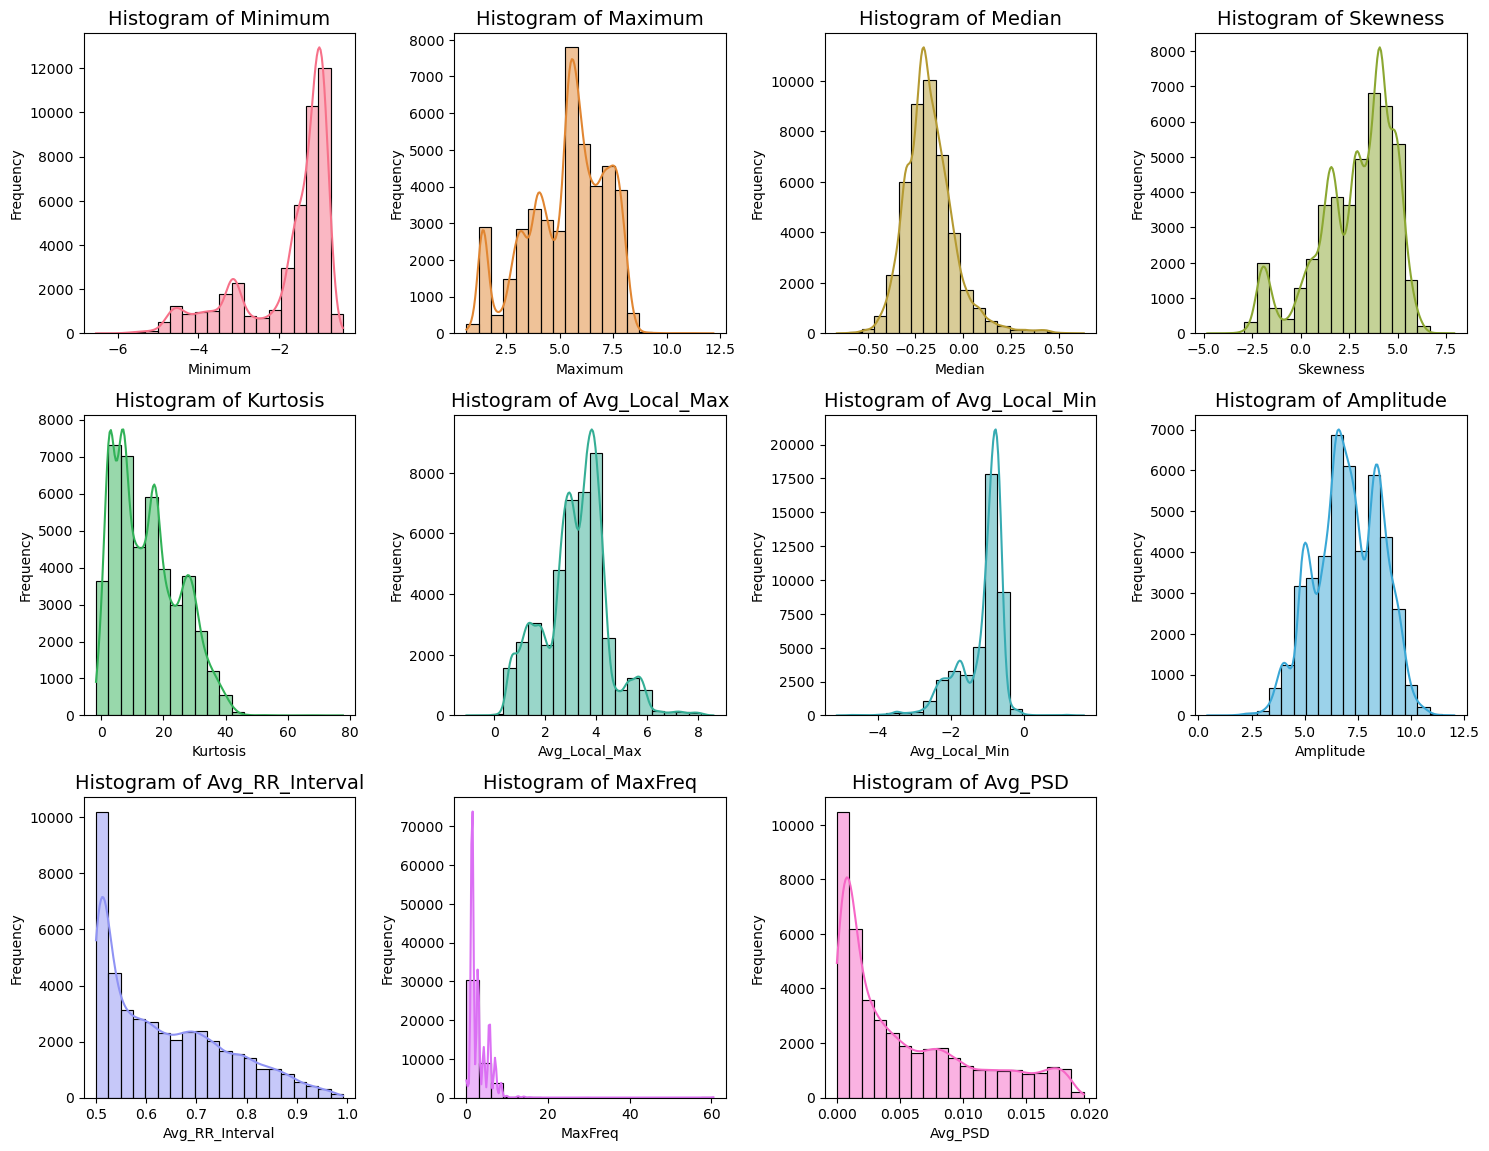

In [41]:
# Define a list of colors for the histograms
colors = sns.color_palette("husl", len(features_dataframe.drop(columns=['P_Wave', 'HeartRate']).columns))

# Univariate Analysis - Histograms
plt.figure(figsize=(15, 15))
for i, column in enumerate(features_dataframe.drop(columns=['P_Wave', 'HeartRate']).columns):
    plt.subplot(4, 4, i + 1) 
    sns.histplot(features_dataframe[column], bins=20, kde=True, color=colors[i])
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


####  4.Comparative Analysis of Numerical Features with P_Wave

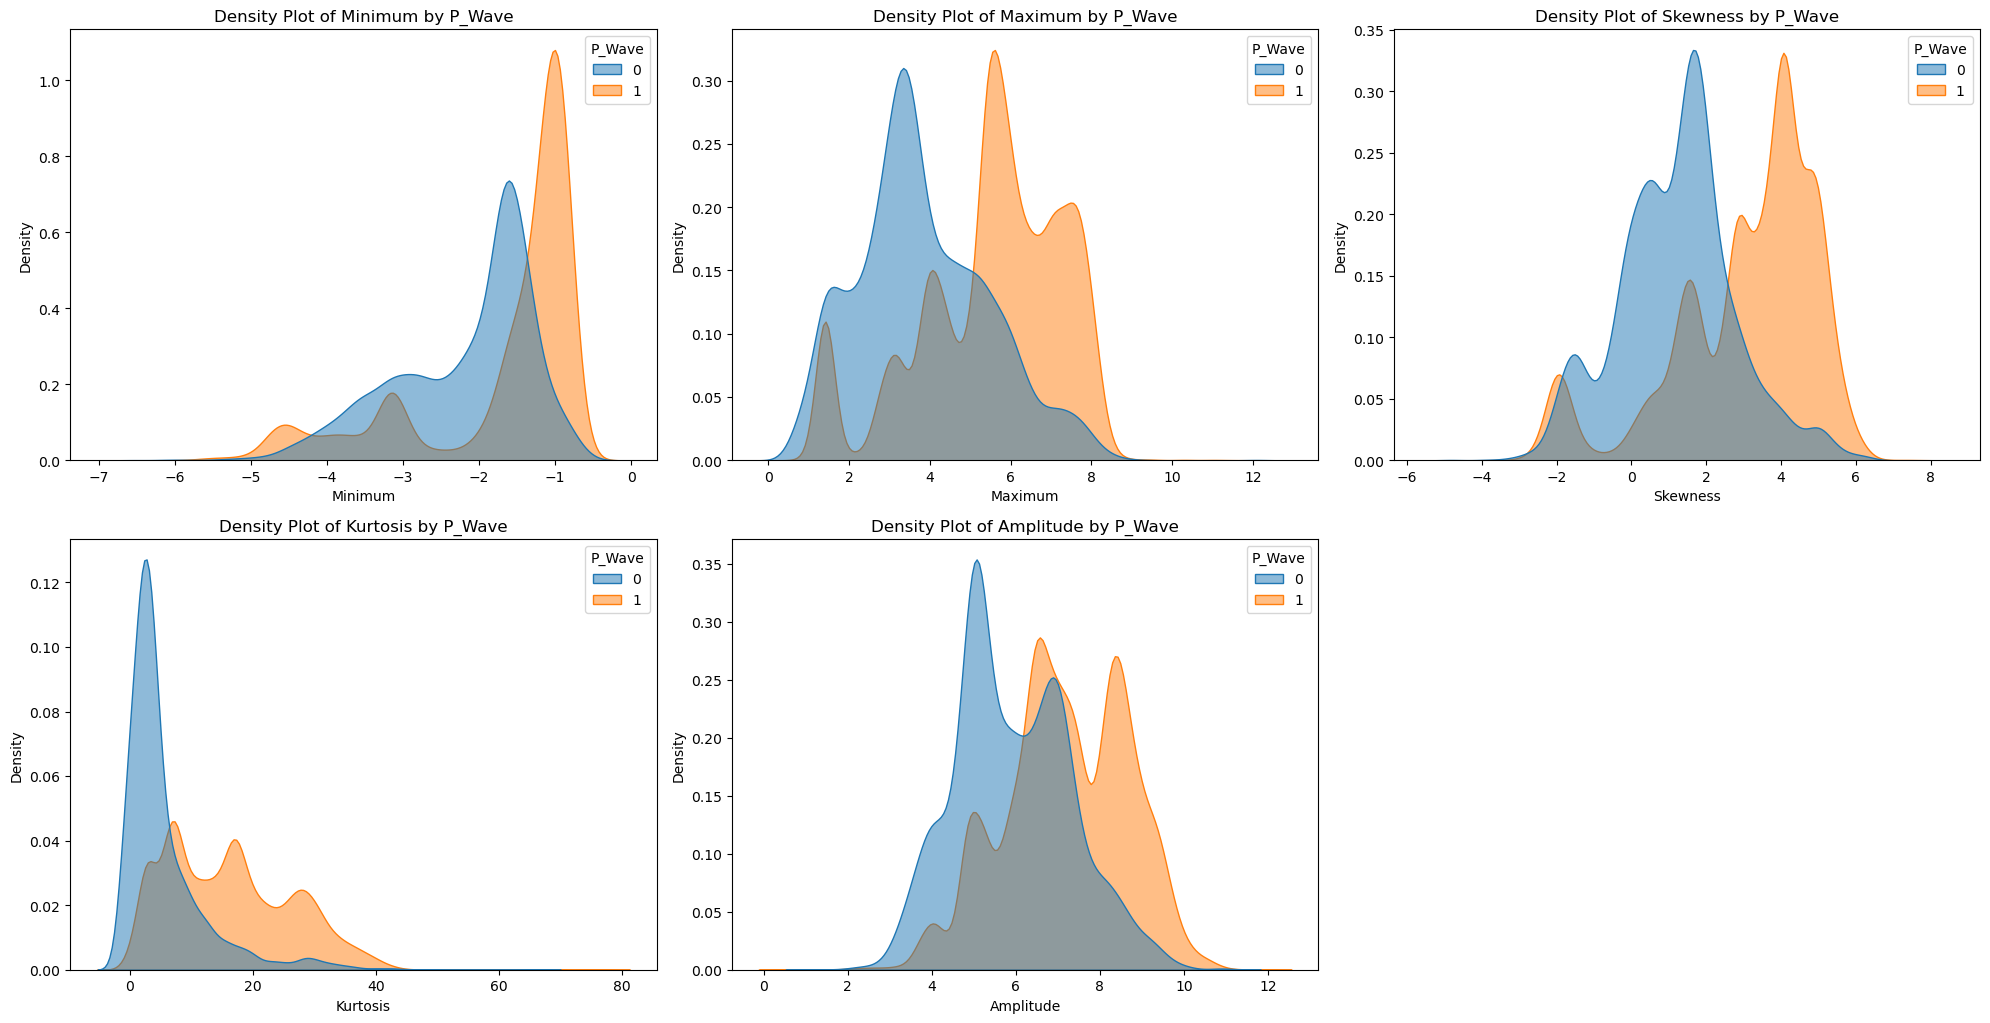

In [96]:
categorical_var = 'P_Wave'

numerical_features = ['Minimum', 'Maximum', 'Skewness', 'Kurtosis', 'Amplitude']
plt.figure(figsize=(20, 15))

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.kdeplot(data=features_dataframe, x=feature, hue=categorical_var, fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Density Plot of {feature} by {categorical_var}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


### Data Splitting Using Stratified Random Sampling

Shape of Training Features (X_train): (30324, 12)
Shape of Training Labels (y_train): (30324,)
Shape of Testing Features (X_test): (12996, 12)
Shape of Testing Labels (y_test): (12996,)


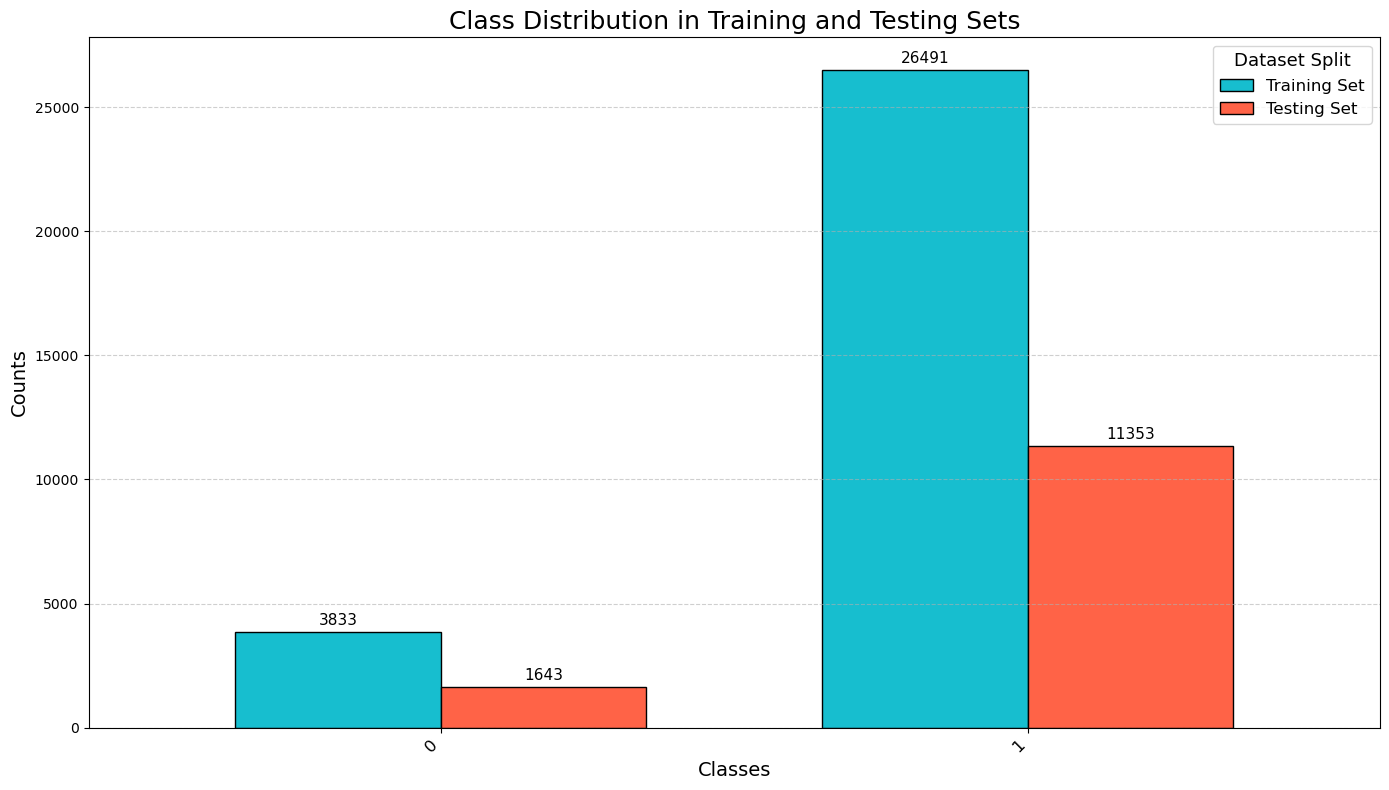

In [47]:
# Data Partitioning using stratified sampling (70% training, 30% testing)
X = features_dataframe.drop(columns=['P_Wave'])
y = features_dataframe['P_Wave']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

train_class_counts = y_train.value_counts().sort_index()
test_class_counts = y_test.value_counts().sort_index()

class_counts_df = pd.DataFrame({
    'Training Set': train_class_counts,
    'Testing Set': test_class_counts
})

print("Shape of Training Features (X_train):", X_train.shape)
print("Shape of Training Labels (y_train):", y_train.shape)
print("Shape of Testing Features (X_test):", X_test.shape)
print("Shape of Testing Labels (y_test):", y_test.shape)


class_names = ["0","1"]


plt.figure(figsize=(14, 8))
ax = class_counts_df.plot(kind='bar', color=['#17becf', '#ff6347'], edgecolor='black', width=0.7, ax=plt.gca())


plt.title('Class Distribution in Training and Testing Sets', fontsize=18)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right', fontsize=12)


plt.grid(axis='y', linestyle='--', alpha=0.6)


plt.legend(title='Dataset Split', fontsize=12, title_fontsize=13)


for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=11, padding=3)


plt.tight_layout()

plt.show()




### Model Building And Performance Evaluation

### 1.Random Forest Classifier: Accuracy and Performance Metrics

In [49]:
# Instantiate and train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics with zero_division to handle undefined precision
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Display metrics in a table
metrics_rf = [
    ["Metric", "Random Forest"],
    ["Accuracy", accuracy_rf],
    ["Precision", precision_rf],
    ["Recall", recall_rf],
    ["F1 Score", f1_rf]
]
print(tabulate(metrics_rf, headers="firstrow", tablefmt="grid"))

# Display confusion matrix with original class names
class_names = ["0","1"]
confusion_rf_df = pd.DataFrame(conf_matrix_rf, index=class_names, columns=class_names)
print("\nConfusion Matrix for Random Forest:")
print(tabulate(confusion_rf_df, headers='keys', tablefmt='grid'))

+-----------+-----------------+
| Metric    |   Random Forest |
+===========+=================+
| Accuracy  |        0.94406  |
+-----------+-----------------+
| Precision |        0.941444 |
+-----------+-----------------+
| Recall    |        0.94406  |
+-----------+-----------------+
| F1 Score  |        0.94175  |
+-----------+-----------------+

Confusion Matrix for Random Forest:
+----+------+-------+
|    |    0 |     1 |
+====+======+=======+
|  0 | 1137 |   506 |
+----+------+-------+
|  1 |  221 | 11132 |
+----+------+-------+


### 2.Gradient Boosting Classifier: Accuracy and Performance Metrics

In [50]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Calculate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Display metrics in a table
metrics_gb = [
    ["Metric", "Gradient Boosting"],
    ["Accuracy", accuracy_gb],
    ["Precision", precision_gb],
    ["Recall", recall_gb],
    ["F1 Score", f1_gb]
]
print(tabulate(metrics_gb, headers="firstrow", tablefmt="grid"))

# Display confusion matrix with original classes
confusion_gb = pd.DataFrame(conf_matrix_gb, index=class_names, columns=class_names)
print("\nConfusion Matrix for Gradient Boosting:")
print(tabulate(confusion_gb, headers='keys', tablefmt='grid'))

+-----------+---------------------+
| Metric    |   Gradient Boosting |
+===========+=====================+
| Accuracy  |            0.928132 |
+-----------+---------------------+
| Precision |            0.923318 |
+-----------+---------------------+
| Recall    |            0.928132 |
+-----------+---------------------+
| F1 Score  |            0.923924 |
+-----------+---------------------+

Confusion Matrix for Gradient Boosting:
+----+-----+-------+
|    |   0 |     1 |
+====+=====+=======+
|  0 | 982 |   661 |
+----+-----+-------+
|  1 | 273 | 11080 |
+----+-----+-------+


### 3.XGBoost Classifier:  Accuracy and Performance Metrics

In [52]:
# Instantiate and train XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display metrics in a table
metrics_xgb = [
    ["Metric", "XGBoost"],
    ["Accuracy", accuracy_xgb],
    ["Precision", precision_xgb],
    ["Recall", recall_xgb],
    ["F1 Score", f1_xgb]
]
print(tabulate(metrics_xgb, headers="firstrow", tablefmt="grid"))

# Display confusion matrix with original class names
class_names = ["0","1"]
confusion_xgb = pd.DataFrame(conf_matrix_xgb, index=class_names, columns=class_names)
print("\nConfusion Matrix for XGBoost:")
print(tabulate(confusion_xgb, headers='keys', tablefmt='grid'))


+-----------+-----------+
| Metric    |   XGBoost |
+===========+===========+
| Accuracy  |  0.945829 |
+-----------+-----------+
| Precision |  0.943744 |
+-----------+-----------+
| Recall    |  0.945829 |
+-----------+-----------+
| F1 Score  |  0.944311 |
+-----------+-----------+

Confusion Matrix for XGBoost:
+----+------+-------+
|    |    0 |     1 |
+====+======+=======+
|  0 | 1191 |   452 |
+----+------+-------+
|  1 |  252 | 11101 |
+----+------+-------+


### Comparative Analysis of Model Performance Metrics

In [53]:
# Create a comparison DataFrame
comparison_metrics = {
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost"],
    "Accuracy": [accuracy_rf, accuracy_gb, accuracy_xgb],
    "Precision": [precision_rf, precision_gb, precision_xgb],
    "Recall": [recall_rf, recall_gb, recall_xgb],
    "F1 Score": [f1_rf, f1_gb, f1_xgb]
}

comparison_df = pd.DataFrame(comparison_metrics)

# Print the comparison table
print("\nModel Comparison Metrics:")
print(tabulate(comparison_df, headers="keys", tablefmt="grid"))


Model Comparison Metrics:
+----+-------------------+------------+-------------+----------+------------+
|    | Model             |   Accuracy |   Precision |   Recall |   F1 Score |
+====+===================+============+=============+==========+============+
|  0 | Random Forest     |   0.94406  |    0.941444 | 0.94406  |   0.94175  |
+----+-------------------+------------+-------------+----------+------------+
|  1 | Gradient Boosting |   0.928132 |    0.923318 | 0.928132 |   0.923924 |
+----+-------------------+------------+-------------+----------+------------+
|  2 | XGBoost           |   0.945829 |    0.943744 | 0.945829 |   0.944311 |
+----+-------------------+------------+-------------+----------+------------+


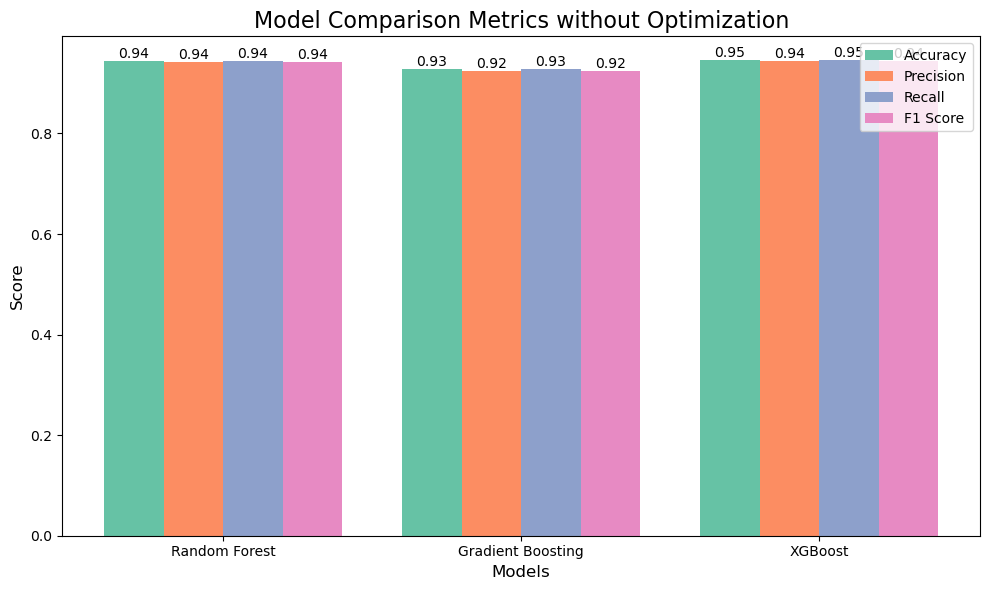

In [63]:
# Set the color palette
palette = sns.color_palette("Set2")

# Plotting the comparison
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.2
index = range(len(comparison_df))

# Create bars for each metric
bars1 = ax.bar(index, comparison_df["Accuracy"], bar_width, label='Accuracy', color=palette[0])
bars2 = ax.bar([i + bar_width for i in index], comparison_df["Precision"], bar_width, label='Precision', color=palette[1])
bars3 = ax.bar([i + 2 * bar_width for i in index], comparison_df["Recall"], bar_width, label='Recall', color=palette[2])
bars4 = ax.bar([i + 3 * bar_width for i in index], comparison_df["F1 Score"], bar_width, label='F1 Score', color=palette[3])

# Adding the value on top of the bars
for bar in bars1 + bars2 + bars3 + bars4:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', ha='center')  # va: vertical alignment

# Set the x-ticks and labels
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(comparison_df["Model"])

# Set title and labels
ax.set_title('Model Comparison Metrics without Optimization', fontsize=16)
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Models', fontsize=12)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Enhanced Model Building and Evaluation through Optimization

### 1.Optimizing Random Forest Classifier: Parameter Tuning and Performance Metrics

In [67]:
# Optimized Random Forest model with GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

# Define a small grid for hyperparameter tuning
param_grid = {
    'n_estimators': [70, 100],       
    'max_depth': [10, 20],           
    'min_samples_split': [5, 10]     
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_rf_model = grid_search.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Display metrics in a table
metrics_rf = [
    ["Metric", "Random Forest"],
    ["Accuracy", accuracy_rf],
    ["Precision", precision_rf],
    ["Recall", recall_rf],
    ["F1 Score", f1_rf]
]
print(tabulate(metrics_rf, headers="firstrow", tablefmt="grid"))

class_names = ["0", "1"]
confusion_rf_df = pd.DataFrame(conf_matrix_rf, index=class_names, columns=class_names)
print("\nConfusion Matrix for Optimized Random Forest:")
print(tabulate(confusion_rf_df, headers='keys', tablefmt='grid'))

# Display best parameters
print("\nBest Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
+-----------+-----------------+
| Metric    |   Random Forest |
+===========+=================+
| Accuracy  |        0.944752 |
+-----------+-----------------+
| Precision |        0.942148 |
+-----------+-----------------+
| Recall    |        0.944752 |
+-----------+-----------------+
| F1 Score  |        0.94221  |
+-----------+-----------------+

Confusion Matrix for Optimized Random Forest:
+----+------+-------+
|    |    0 |     1 |
+====+======+=======+
|  0 | 1127 |   516 |
+----+------+-------+
|  1 |  202 | 11151 |
+----+------+-------+

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


### 2.Optimizing Gradient Boosting Classifier: Parameter Tuning and Performance Metrics

In [69]:
# Instantiate Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Define a small grid for hyperparameter tuning
param_grid = {
    'n_estimators': [70, 100],        
    'learning_rate': [0.1, 0.05],     
    'max_depth': [3, 5]              
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_gb_model = grid_search.best_estimator_

# Predictions
y_pred_gb = best_gb_model.predict(X_test)

# Calculate metrics 
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted', zero_division=0)
recall_gb = recall_score(y_test, y_pred_gb, average='weighted', zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Display metrics in a table
metrics_gb = [
    ["Metric", "Gradient Boosting"],
    ["Accuracy", accuracy_gb],
    ["Precision", precision_gb],
    ["Recall", recall_gb],
    ["F1 Score", f1_gb]
]
print(tabulate(metrics_gb, headers="firstrow", tablefmt="grid"))

class_names = ["0", "1"]
confusion_gb_df = pd.DataFrame(conf_matrix_gb, index=class_names, columns=class_names)
print("\nConfusion Matrix for Optimized Gradient Boosting:")
print(tabulate(confusion_gb_df, headers='keys', tablefmt='grid'))

# Display best parameters
print("\nBest Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
+-----------+---------------------+
| Metric    |   Gradient Boosting |
+===========+=====================+
| Accuracy  |            0.93775  |
+-----------+---------------------+
| Precision |            0.93468  |
+-----------+---------------------+
| Recall    |            0.93775  |
+-----------+---------------------+
| F1 Score  |            0.935399 |
+-----------+---------------------+

Confusion Matrix for Optimized Gradient Boosting:
+----+------+-------+
|    |    0 |     1 |
+====+======+=======+
|  0 | 1107 |   536 |
+----+------+-------+
|  1 |  273 | 11080 |
+----+------+-------+

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


### 3.Optimizing XG Boost Classifier: Parameter Tuning and Performance Metrics

In [97]:
# Instantiate XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Define a refined grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300],             
    'learning_rate': [0.1, 0.05, 0.01],     
    'max_depth': [3, 4, 5],                 
    'subsample': [0.8, 0.9],                
    'colsample_bytree': [0.8, 1.0],         
    'gamma': [0, 0.1, 0.3]                  
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate metrics with zero_division to handle undefined precision
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display metrics in a table
metrics_xgb = [
    ["Metric", "XGBoost"],
    ["Accuracy", accuracy_xgb],
    ["Precision", precision_xgb],
    ["Recall", recall_xgb],
    ["F1 Score", f1_xgb]
]
print(tabulate(metrics_xgb, headers="firstrow", tablefmt="grid"))

class_names = ["0", "1"]
confusion_xgb_df = pd.DataFrame(conf_matrix_xgb, index=class_names, columns=class_names)
print("\nConfusion Matrix for Optimized XGBoost:")
print(tabulate(confusion_xgb_df, headers='keys', tablefmt='grid'))

# Display best parameters
print("\nBest Parameters:", grid_search.best_params_)




Fitting 3 folds for each of 216 candidates, totalling 648 fits
+-----------+-----------+
| Metric    |   XGBoost |
+===========+===========+
| Accuracy  |  0.944521 |
+-----------+-----------+
| Precision |  0.942285 |
+-----------+-----------+
| Recall    |  0.944521 |
+-----------+-----------+
| F1 Score  |  0.942873 |
+-----------+-----------+

Confusion Matrix for Optimized XGBoost:
+----+------+-------+
|    |    0 |     1 |
+====+======+=======+
|  0 | 1177 |   466 |
+----+------+-------+
|  1 |  255 | 11098 |
+----+------+-------+

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


### Comparative Analysis of Optimized Model Performance Metrics

+-----------+-----------------+---------------------+-----------+
| Metric    |   Random Forest |   Gradient Boosting |   XGBoost |
+===========+=================+=====================+===========+
| Accuracy  |        0.944752 |            0.93775  |  0.944521 |
+-----------+-----------------+---------------------+-----------+
| Precision |        0.942148 |            0.93468  |  0.942285 |
+-----------+-----------------+---------------------+-----------+
| Recall    |        0.944752 |            0.93775  |  0.944521 |
+-----------+-----------------+---------------------+-----------+
| F1 Score  |        0.94221  |            0.935399 |  0.942873 |
+-----------+-----------------+---------------------+-----------+


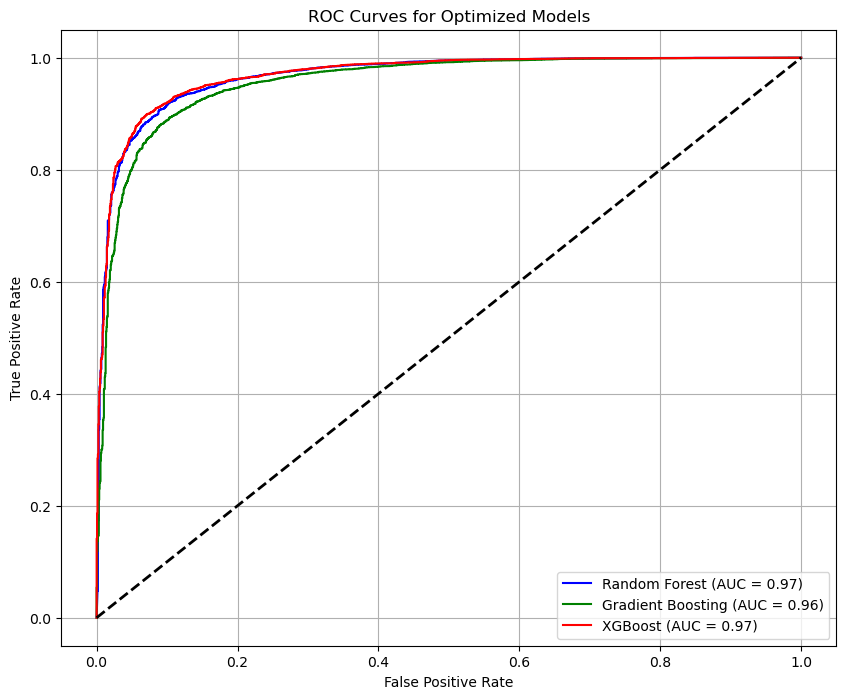

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Comparison Table
comparison_metrics = [
    ["Metric", "Random Forest", "Gradient Boosting", "XGBoost"],
    ["Accuracy", accuracy_rf, accuracy_gb, accuracy_xgb],
    ["Precision", precision_rf, precision_gb, precision_xgb],
    ["Recall", recall_rf, recall_gb, recall_xgb],
    ["F1 Score", f1_rf, f1_gb, f1_xgb]
]
print(tabulate(comparison_metrics, headers="firstrow", tablefmt="grid"))

# Plot ROC Curves
plt.figure(figsize=(10, 8))

# Random Forest ROC and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {auc_rf:.2f})')

# Gradient Boosting ROC and AUC
fpr_gb, tpr_gb, _ = roc_curve(y_test, best_gb_model.predict_proba(X_test)[:, 1])
auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, color='green', label=f'Gradient Boosting (AUC = {auc_gb:.2f})')

# XGBoost ROC and AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_model.predict_proba(X_test)[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, color='red', label=f'XGBoost (AUC = {auc_xgb:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Optimized Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


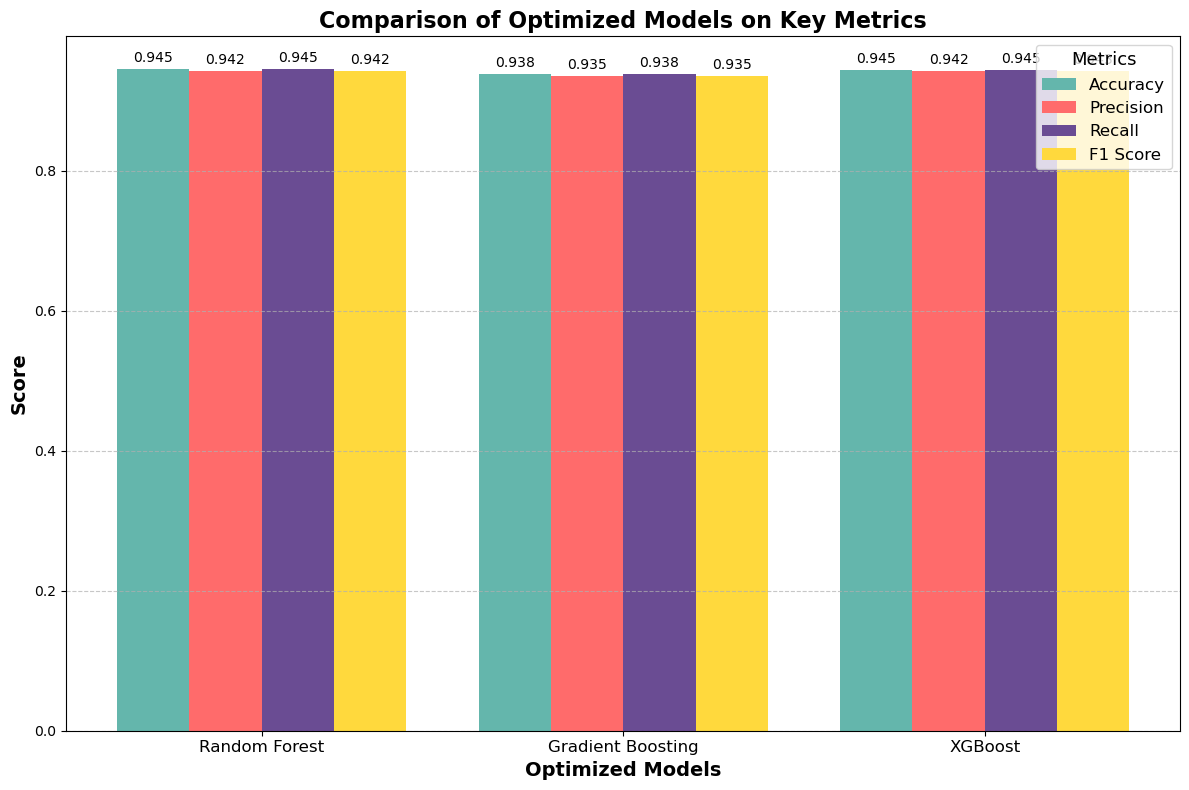

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and their respective metrics
models = ["Random Forest", "Gradient Boosting", "XGBoost"]
accuracy = [accuracy_rf, accuracy_gb, accuracy_xgb]
precision = [precision_rf, precision_gb, precision_xgb]
recall = [recall_rf, recall_gb, recall_xgb]
f1_score = [f1_rf, f1_gb, f1_xgb]

# Define a fresh pastel color palette and bar width
colors = ["#64b6ac", "#ff6b6b", "#6a4c93", "#ffd93d"]  # Teal, Coral, Lavender, Mustard
bar_width = 0.2

# Set x locations for each model
x = np.arange(len(models))


plt.figure(figsize=(12, 8))
plt.bar(x - bar_width*1.5, accuracy, width=bar_width, color=colors[0], label="Accuracy")
plt.bar(x - bar_width/2, precision, width=bar_width, color=colors[1], label="Precision")
plt.bar(x + bar_width/2, recall, width=bar_width, color=colors[2], label="Recall")
plt.bar(x + bar_width*1.5, f1_score, width=bar_width, color=colors[3], label="F1 Score")

# Add labels and title
plt.xlabel("Optimized Models", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontsize=14, fontweight='bold')
plt.title("Comparison of Optimized Models on Key Metrics", fontsize=16, fontweight='bold')
plt.xticks(x, models, fontsize=12)


for i in range(len(models)):
    plt.text(x[i] - bar_width*1.5, accuracy[i] + 0.01, f"{accuracy[i]:.3f}", ha="center", color="black", fontsize=10)
    plt.text(x[i] - bar_width/2, precision[i] + 0.01, f"{precision[i]:.3f}", ha="center", color="black", fontsize=10)
    plt.text(x[i] + bar_width/2, recall[i] + 0.01, f"{recall[i]:.3f}", ha="center", color="black", fontsize=10)
    plt.text(x[i] + bar_width*1.5, f1_score[i] + 0.01, f"{f1_score[i]:.3f}", ha="center", color="black", fontsize=10)

# Display legend and grid
plt.legend(title="Metrics", fontsize=12, title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot with tight layout
plt.tight_layout()
plt.show()


### Comparative Analysis and Conclusion of Model Performance: Optimized vs. Non-Optimized Metrics